In [1]:
import pymysql
import pandas as pd
import numpy as np
from pathlib import Path
import requests
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
import threading
import time
from leuvenmapmatching import visualization as mmviz
import osmread
from sklearn.cluster import DBSCAN
from  decimal import Decimal
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import math as m
from haversine import haversine

In [6]:
# 数据库连接
def getTrajectory():
    # 打开数据库连接
    db = pymysql.connect("localhost", "root", "123456", "test", charset='utf8' )
    # 使用cursor()方法获取操作游标 
    cursor = db.cursor()
    sql = "SELECT * FROM taxi where id = 1131" 
    try:
       # 执行SQL语句
        cursor.execute(sql)
       # 获取所有记录列表
        results = np.array(cursor.fetchall())
    except:
        print ("Error: unable to fetch data")
    # 关闭数据库连接
    db.close()
    return results

In [7]:
# 用DBSCAN打上标签过滤
def markLabel(TRFromMysql,sleepTime = 108000):
    db = DBSCAN(eps=0.01, min_samples=3)
    # 数据转换
    def convertDate(Date_time):
        DateLiet = Date_time.values
        timestamp = []
        for item in DateLiet:
            Date_time = int(time.mktime(item.timetuple()))
            timestamp.append(Date_time)
        return timestamp
    TR = pd.DataFrame(TRFromMysql)
    print ('原始数据大小',len(TR))
    TR[[3]] = TR[[3]].apply(convertDate)
    # 打上标签
    db.fit(np.array(TR)[:,1:3])
    TR['label'] = db.labels_
    # 去除停留点
    stopCluser = []
    groups = TR.groupby('label')
    for clusterID, cluster in groups:
        if clusterID != -1 and len(cluster)> 5 and (cluster[3].max()-cluster[3].min()) > sleepTime:
            stopCluser.append(clusterID)
    TR = TR[~TR['label'].isin(stopCluser)]
    print('去掉停留点后数据大小',len(TR))
    # 去除新数据噪声
    db.fit(np.array(TR)[:,1:3])
    TR['label'] = db.labels_
    TR = TR[~TR['label'].isin([-1])]
    print('去掉噪声后数据大小',len(TR))
    return TR

In [8]:
TR = markLabel(getTrajectory())

原始数据大小 4147
去掉停留点后数据大小 240
去掉噪声后数据大小 213


D:\anaconda\envs\Juah\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# 得到路径与坐标box
def getPath_Box(TR):
    path = np.array(TR.apply(lambda x:(float(x[1]),float(x[2])),axis=1))

    box = np.array(pd.DataFrame(TR)[[1,2]].apply(['max','min']))
    boxList = list(box[:,1])+list(box[:,0])
    return path, boxList

In [6]:
path,locationBox = getPath_Box(TR)

In [7]:
locationBoxA

[Decimal('40.0822'),
 Decimal('39.8411'),
 Decimal('116.40952'),
 Decimal('116.25888')]

In [8]:
# org = (27.5075, 77.6779)
# dst = (27.5067, 77.6694)
# dist = 1000
# north, south, east, west = ox.bbox_from_point(org, distance=dist)

In [9]:
G = ox.graph_from_bbox(north=locationBox[0], south=locationBox[1], east=locationBox[2], west=locationBox[3],
                       retain_all=True, truncate_by_edge=True, simplify=False,
                       network_type='drive')
#下载旧金山的OSM道路网络数据,并将其保存为shp和graphml两种格式：
#G = ox.graph_from_place(' San Francisco ',network_type='drive')
ox.save_graph_shapefile(G)
ox.save_graphml(G)

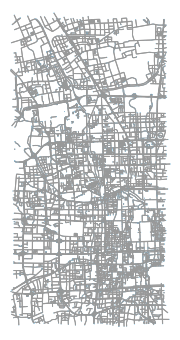

In [10]:
fig, ax = ox.plot_graph(ox.project_graph(G),node_size=0.5)

In [11]:
def getNodeNumber(point,G):
    node = ox.get_nearest_node(G,point)
    return node

In [12]:
trajectoryNodes = list(pd.DataFrame(path)[0].apply(getNodeNumber,args = (G,)))
route_list = []
for index,node in enumerate(trajectoryNodes):
    if index == len(trajectoryNodes)-1:
        continue
    route = nx.shortest_path(G, source=node, target=trajectoryNodes[index+1], weight='length', method='dijkstra')
    route_list.append(route)

In [55]:
route_list

[[1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951],
 [1652645951]]

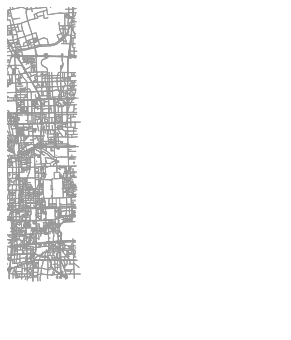

In [56]:
# fig, ax = ox.plot_graph_route(G, route_list, node_size=0)
fig, ax =ox.plot_graph_route(G, route,node_size=0.5,bbox=(40.0565,39.8018, 116.62592, 116.34323))

In [3]:
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap

map_con = InMemMap("mymap", graph={
    "A": ((1, 1), ["B", "C", "X"]),
    "B": ((1, 3), ["A", "C", "D", "K"]),
    "C": ((2, 2), ["A", "B", "D", "E", "X", "Y"]),
    "D": ((2, 4), ["B", "C", "F", "E", "K", "L"]),
    "E": ((3, 3), ["C", "D", "F", "Y"]),
    "F": ((3, 5), ["D", "E", "L"]),
    "X": ((2, 0), ["A", "C", "Y"]),
    "Y": ((3, 1), ["X", "C", "E"]),
    "K": ((1, 5), ["B", "D", "L"]),
    "L": ((2, 6), ["K", "D", "F"])
}, use_latlon=False)

path = [(0.8, 0.7), (0.9, 0.7), (1.1, 1.0), (1.2, 1.5), (1.2, 1.6), (1.1, 2.0),
        (1.1, 2.3), (1.3, 2.9), (1.2, 3.1), (1.5, 3.2), (1.8, 3.5), (2.0, 3.7),
        (2.3, 3.5), (2.4, 3.2), (2.6, 3.1), (2.9, 3.1), (3.0, 3.2),
        (3.1, 3.8), (3.0, 4.0), (3.1, 4.3), (3.1, 4.6), (3.0, 4.9)]

matcher = DistanceMatcher(map_con, max_dist=2, obs_noise=1, min_prob_norm=0.5)
states, _ = matcher.match(path)
nodes = matcher.path_pred_onlynodes

print("States\n------")
print(states)
print("Nodes\n------")
print(nodes)
print("")
matcher.print_lattice_stats()

Searching closeby nodes with linear search, use an index and set max_dist


States
------
[('X', 'A'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('B', 'D'), ('B', 'D'), ('B', 'D'), ('B', 'D'), ('D', 'E'), ('D', 'E'), ('D', 'E'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F')]
Nodes
------
['X', 'A', 'B', 'D', 'E', 'F']

Stats lattice
-------------
nbr levels               : 22
nbr lattice              : 1002
avg lattice[level]       : 45.54545454545455
min lattice[level]       : 7
max lattice[level]       : 97
avg obs distance         : 0.15514927458475236
last logprob             : -0.5464565099511667
last length              : 22
last norm logprob        : -0.024838932270507576
